<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Image Classification with Convolutional Neural Network
Dataset: [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification/data#)

Goal: Classify images into 6 categories: building, forest, glacier, mountain, sea, and street.

In [7]:
# Import essential libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob as gb 
import cv2
import os, random
import seaborn as sns
from keras.preprocessing import image
import sklearn


In [8]:

# Checking the GPU installed
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


# Loading data from Kaggle

In [9]:
# Install Kaggle library
!pip install -q kaggle

# Loading kaggle API key file
!cd ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [10]:
# Downloading the dataset from Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzipping the dataset
!unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# Exploring Data

In [11]:
# Directory paths
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

In [12]:
os.listdir(train_path)

['sea', 'buildings', 'forest', 'mountain', 'street', 'glacier']

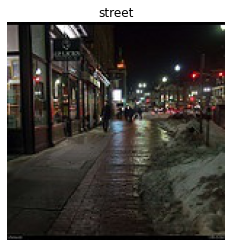

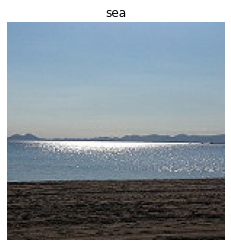

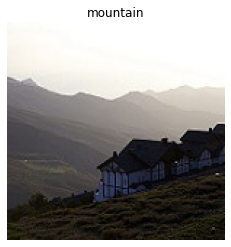

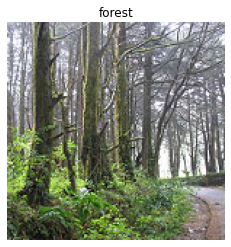

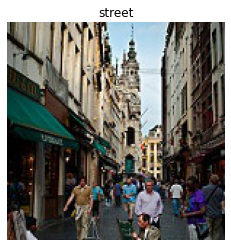

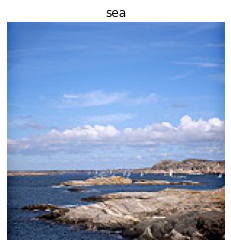

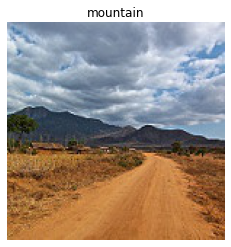

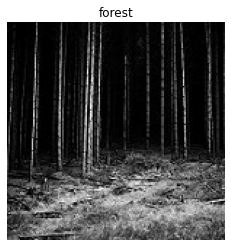

In [16]:
# Showing some images to observe
def show_pictures(path,class_):
    selected_fpath = random.choice(gb.glob(pathname = path+ '/'+ class_+'/*.jpg'))
    img = image.load_img(selected_fpath, target_size=(150, 150))
    ## Encoding image into integer in the 0–255 range
    image_tensor = image.img_to_array(img)  
    # Nomalizing the pixel in [0, 1]
    image_tensor /= 255 
    plt.imshow(image_tensor)
    plt.title(class_)
    plt.axis("off")
    plt.show()

for i in range(0,2):
    show_pictures(train_path, 'street')
    show_pictures(train_path, 'sea')
    show_pictures(test_path, 'mountain')
    show_pictures(test_path, 'forest')


In [ ]:
# Exploring sizes of the training, testing and prediction sets
def exploring_size (path):
  size =0
  try:
    for name in os.listdir(path):
      size += len(os.listdir(path + '/' + name))
  except:
    size += len(os.listdir(path))
  return size

print('The number of images in the training set: ', exploring_size(train_path))
print('The number of images in the test set: ', exploring_size(test_path))
print('The number of images in the prediction set: ', exploring_size(pred_path))

The number of images in the training set:  14034
The number of images in the test set:  3000
The number of images in the prediction set:  7301


In [ ]:
# Exploring data's labels 
folder_names = os.listdir(train_path)
print('All labels: ', folder_names)

# Exploring data distribution in the training set
print ('-'*30, '\nData distributed in the training set:')
for name in folder_names:
  print (name, ': ', len(os.listdir(train_path + '/' + name)))

# Exploring data distributed in the test set
print ('-'*30, '\nData distributed in the test set:')
for name in folder_names:
  print (name, ': ', len(os.listdir(test_path + '/' + name)))

All labels:  ['sea', 'buildings', 'forest', 'mountain', 'street', 'glacier']
------------------------------ 
Data distributed in the training set:
sea :  2274
buildings :  2191
forest :  2271
mountain :  2512
street :  2382
glacier :  2404
------------------------------ 
Data distributed in the test set:
sea :  510
buildings :  437
forest :  474
mountain :  525
street :  501
glacier :  553


We can see the data are equally distributed over 6 categories.

In [ ]:
# Exploring the images' sizes
def explore_image_size (path):
  size = []
  for name in os.listdir(path):
    file_paths = gb.glob(pathname = path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      size.append(plt.imread(p).shape)
  return pd.DataFrame(size, columns = ['H', 'W', 'D']).value_counts()
  
print('Image sizes in the training set\n',  explore_image_size (train_path))
print('\nImage sizes in the test set\n',  explore_image_size (test_path))


Image sizes in the training set
 H    W    D
150  150  3    13986
113  150  3        7
135  150  3        3
111  150  3        3
144  150  3        2
143  150  3        2
142  150  3        2
146  150  3        2
136  150  3        2
134  150  3        2
108  150  3        2
123  150  3        2
97   150  3        1
100  150  3        1
81   150  3        1
103  150  3        1
105  150  3        1
110  150  3        1
102  150  3        1
124  150  3        1
115  150  3        1
119  150  3        1
120  150  3        1
149  150  3        1
131  150  3        1
133  150  3        1
140  150  3        1
141  150  3        1
145  150  3        1
147  150  3        1
76   150  3        1
dtype: int64

Image sizes in the test set
 H    W    D
150  150  3    2993
149  150  3       1
141  150  3       1
131  150  3       1
110  150  3       1
81   150  3       1
76   150  3       1
72   150  3       1
dtype: int64


We can see  that most images have the size 150x150x3. It's reasonable to resize all images to this size. However, we want to reduce all images into a size of 64x64x3 to save the training time if we evaluate the model with K-fold cross validation that is very expensive for the image classifier. 

# Model 1: A base CNN model

## Data Preprocessing
* To build the CNN model, we have to preprocess the whole data, including training set, testing set, and prediction set. First, we would like to rescale our images so that every image's pixel value ranges between 0 and 1.
Futher, we will apply data augmentation methods for the training set since our training set is not too large. We can generate variants by varying shear, rotation, zoom, etc. By doing so, we hope to avoid overfitting of the model in future. 

In [ ]:
# Preprocessing the train and test data
## Creating generator models for preprocessing and data agmentation
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
test_generator = ImageDataGenerator(rescale = 1./255)

## Passing the data over the generator model
train_generated = train_generator.flow_from_directory(train_path,
                                                      target_size = (64,64),
                                                      class_mode = 'sparse',
                                                      shuffle = True,
                                                      batch_size=32)
test_generated = test_generator.flow_from_directory(test_path, 
                                                    target_size = (64,64),
                                                    class_mode = 'sparse',
                                                    shuffle=False,
                                                    batch_size=32)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# Getting classes encoded
label_encoding = train_generated.class_indices
label_encoding

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

* **Preprocessing the training dataset for K-fold cross validation**: For training and testing the model on the whole training and testing set, it could be more convenient to preprocess and store data by using .flow_from_directory. However, we aimed to validate the model with K-fold Cross validation that requires us to divide the training set into K-folds. Therefore, this step is beneficial for our model validation later on. Also, we are going to reduce the sizes of images to (64,64) that hopefully can speed up our K-fold cross validation.



In [ ]:
# Getting images and labels stored in two lists 

## Defining a function for getting both images (x) and labels (y)
def get_xy (path):
  X, y = [],[]
  for name in os.listdir(path):
    file_paths = gb.glob(pathname = path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      image = plt.imread(p)
      resized_image = cv2.resize(image,(64,64) )
      X.append(resized_image)
      y.append(label_encoding[name])
  return X, y

## Defining a function for getting only images (x) since prediction set has no labels
def get_x (path):
  X = []
  for name in os.listdir(path):
    path_file = path+'/'+ name
    image = plt.imread(path_file)
    resized_image = cv2.resize(image,(64,64) )
    X.append(resized_image)
  return X 

# For images in the training set
X_train, y_train = get_xy (train_path)
print('The number of images in the training set:', len(X_train), len(y_train))

#For images in the predicting set
X_pred = get_x (pred_path)
print('The number of images in the predicting set:', len(X_pred))

The number of images in the training set: 14034 14034
The number of images in the predicting set: 7301


* Converting the data lists we had previously into arrays, and shuffling them well before splitting for K-fold cross validation

In [ ]:
# Converting data lists into arrays, and shuffling them
from sklearn.utils import shuffle
X_train, y_train = sklearn.utils.shuffle(np.array(X_train), np.array(y_train), random_state = 42)
X_pred = np.array(X_pred)

print('The shape of X_train:', X_train.shape)
print('The shape of y_train:', y_train.shape)
print('The shape of X_pred:', X_pred.shape)

The shape of X_train: (14034, 64, 64, 3)
The shape of y_train: (14034,)
The shape of X_pred: (7301, 64, 64, 3)


## Training the CNN model

In [ ]:
# Creating the architecture of the CNN model
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

## Defining a CNN model
def define_cnn():
  # Creating the model
  cnn = Sequential()

  # Convolution 1
  cnn.add(Conv2D(32, (3,3), activation='relu', input_shape = (64,64,3)))
  # Maxpooling 1
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Convolution 2
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  # Maxpooling 2
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Convolution 3
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  #  Maxpooling 3
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Flatten
  cnn.add(Flatten())
  
  # Fully-connected NN layer
  cnn.add(Dense(32, activation = 'relu'))
  cnn.add(Dense(16, activation = 'relu'))
  cnn.add(Dense(6, activation = 'softmax'))
  return cnn



In [ ]:
# Defining 10-fold cross validation for validating the model in the training set
kfold = KFold(n_splits = 10, shuffle = True)
fold_accuracy = []
fold_loss = []
fold = 1

for train, test in kfold.split(np.zeros(len(y_train)),y_train): ## kfold.split just splitting the data indices into fold, so we can use np.zero for getting the indices
  ## Applying the data generator models to process data 
  train_generated = train_generator.flow(X_train[train], y_train[train], batch_size=32)
  val_generated = test_generator.flow(X_train[test], y_train[test], batch_size=32)
  
  ## Creating the cnn model
  cnn = define_cnn()
  
  ## Compiling the model
  cnn.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
  print ('-'*35, '\nTraining on fold {}'.format(fold))

  ## Fitting the model into the training set
  history = cnn.fit(train_generated,  
                    epochs = 5,
                    validation_data=(val_generated) )
  
  ## Creating validation metrics
  scores = cnn.evaluate(val_generated, verbose=1)
  print(f"Score of fold: {fold}: {cnn.metrics_names[0]} is {scores[0]}, {cnn.metrics_names[1]} is {scores[1]}")
  
  ## Getting loss and accuracy scores of all folds
  fold_loss.append(scores[0])
  fold_accuracy.append(scores[1])
  fold += 1

# Printing the average scores of 10 folders to get the generalized scores of the model
print('-'*35)
print('The generalized scores of the model:')
print('Accuracy: ', np.mean(fold_accuracy))
print('Loss: ', np.mean(fold_loss))


----------------------------------- 
Training on fold 1
Epoch 1/5
395/395 [==============================] - 48s 39ms/step - loss: 1.3753 - accuracy: 0.4544 - val_loss: 1.1591 - val_accuracy: 0.5705
Epoch 2/5
395/395 [==============================] - 15s 38ms/step - loss: 0.9386 - accuracy: 0.6480 - val_loss: 0.8707 - val_accuracy: 0.6652
Epoch 3/5
395/395 [==============================] - 15s 38ms/step - loss: 0.8456 - accuracy: 0.6861 - val_loss: 0.7463 - val_accuracy: 0.7215
Epoch 4/5
395/395 [==============================] - 15s 37ms/step - loss: 0.7372 - accuracy: 0.7244 - val_loss: 0.7083 - val_accuracy: 0.7322
Epoch 5/5
44/44 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.7650
Score of fold: 1: loss is 0.6508198976516724, accuracy is 0.7649572491645813
----------------------------------- 
Training on fold 2
Epoch 1/5
395/395 [==============================] - 15s 37ms/step - loss: 1.3869 - accuracy: 0.4121 - val_loss: 0.9715 - val_accuracy: 0.6325

In [ ]:
cnn.summary()
print('The number of layers: ', len(cnn.layers))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2304)             

**Model's architectures:**

Our CNN model has 130,710 parameters in total. The model has 10 layers with 6 layers divided into three convolution layer blocks. For each convolution layer block, we stride filters with size (3,3) over the image, take the dot products, and apply RELU activation to generate feature maps. After that, we downsample those feature maps using MaxPooling with filter size (2,2). We use 32 filters in the first convolution layer block, and 64 filters for the two last convolution layer blocks. The convolution ends up with 2304 kernels or neural that will be flattened as input of the fully-connect neural network. We use two hidden layers with RELU activations, but we use softmax activation in the output layers in this fully-connect neural network. The input values of this final layers could be positive, negative, zero or greater than 1. The softmax activation would turn them into probability-like numbers ranging between 0 and 1. This layer will end up with probabilities of the 6 classes.

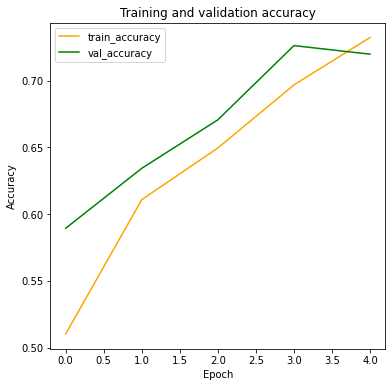

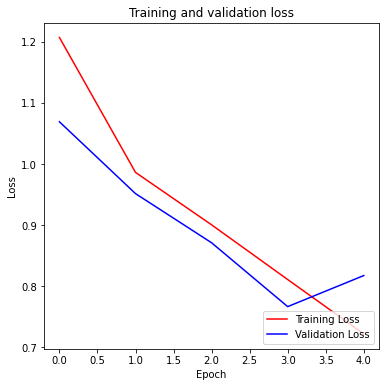

In [ ]:
# Plotting the performance of the model over training
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],'orange', label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], 'g', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.show()

plt.figure(figsize=(6,6))
plt.plot( history.history['loss'], 'r', label='Training Loss')
plt.plot( history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.legend(loc = 'lower right')
plt.show()

We trained the model on 5 epochs over each of 10 k-fold. The generalized scores shows that the CNN model we built performs not very well, just around 75% accuracy, but importantly, the models did not show overfitting in the validation set. Therefore, for some purposes, we believe the model can be deployed in real world.

Now, let see how the model performs on the testing set that we have not touched in the training process:

In [ ]:
# Fitting the model in the whole training set
cnn.fit(train_generated, epochs = 5,  verbose = 1)
# Observing the performance of the model on the testing set 
model_loss, model_accuracy = cnn.evaluate(test_generated)
print('Loss is: ', model_loss)
print('Accuracy is: ', model_accuracy)

Epoch 1/5
395/395 [==============================] - 14s 36ms/step - loss: 0.6764 - accuracy: 0.7524
Epoch 2/5
395/395 [==============================] - 14s 36ms/step - loss: 0.6393 - accuracy: 0.7660
Epoch 3/5
395/395 [==============================] - 14s 36ms/step - loss: 0.6081 - accuracy: 0.7819
Epoch 4/5
395/395 [==============================] - 14s 35ms/step - loss: 0.5893 - accuracy: 0.7873
Epoch 5/5
94/94 [==============================] - 3s 31ms/step - loss: 0.5930 - accuracy: 0.7927
Loss is:  0.5930380821228027
Accuracy is:  0.7926666736602783


Surprisingly, the model even achieved higher performance on the test set, around 79% accuracy. This indicates that the model did not have enough training. In the future, we can increase more epochs to improve its performance. 

## Evaluating the CNN model on the testing set

* **Observing the classification report**


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Applying the model to predict on the test set
y_pred = np.argmax(cnn.predict(test_generated), axis=-1) 
y_true = test_generated.classes

# Printing class
print(classification_report(y_true, y_pred, target_names=label_encoding))


              precision    recall  f1-score   support

   buildings       0.85      0.64      0.73       437
      forest       0.88      0.95      0.92       474
     glacier       0.82      0.66      0.74       553
    mountain       0.77      0.76      0.77       525
         sea       0.74      0.84      0.79       510
      street       0.73      0.90      0.81       501

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000



We can see the model performs quite well in the testing set with 79% accuracy. Recall scores are quite high in most categories. The models predicted in the glacier and building categories a bit worse than other categories.  

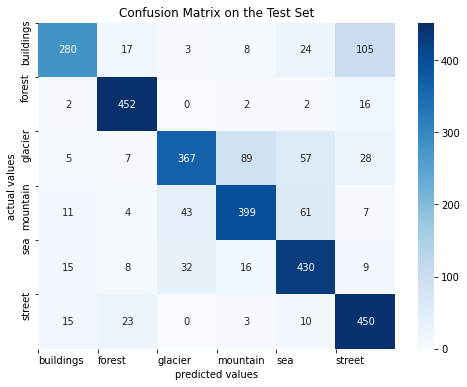

In [ ]:
# Evaluating the model with confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

## Visualizing the confusion matrix
label_names = [k for k in label_encoding.keys()]
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot = True, fmt=".0f", cmap = 'Blues' )
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, horizontalalignment='left')
plt.yticks(tick_marks, label_names)
plt.xlabel ('predicted values')
plt.ylabel ('actual values')
plt.title('Confusion Matrix on the Test Set')
plt.show()

## Applying the model for predicting the real-world images

In [ ]:
# Preprocessing the images in the prediction set for prediction
pred_generator = ImageDataGenerator(rescale = 1./255)
pred_generated = pred_generator.flow(X_pred, batch_size=32, shuffle = False)

# Applying the model to predict
y_pred = cnn.predict(pred_generated, batch_size=32)


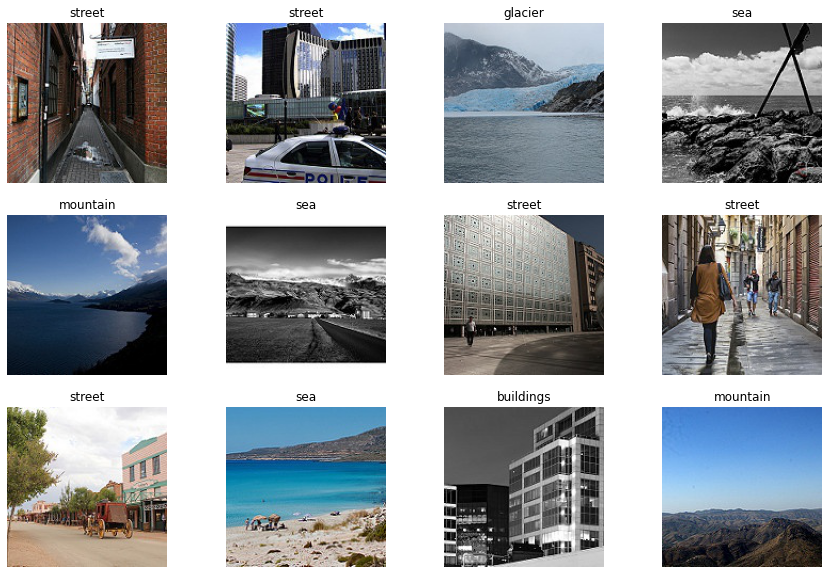

In [ ]:
# Defining the function for predicting the unseen data
from skimage import transform

def load_image(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image = transform.resize(np_image, (64, 64, 3))
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

# Getting the encoded classes and labels
classes_decoded = dict([(v, k) for k, v in label_encoding.items()])

# Randomly picking up 12 images for predicting
plt.figure(figsize=(15,10))
for i in range (12):
  ax = plt.subplot(3,4,i+1)
  img = load_image(pred_path)
  label=np.argmax(cnn.predict(img[1]), axis=-1)
  plt.title(classes_decoded[int(label)])
  plt.imshow(img[0])
  plt.axis("off")
   

We can easily realize that the model predicts wrongly some images.

# Model 2: A CNN model based on transfer learning
Deep learning obviously outperforms the traditional machine learning; however, deep learning requires to train in a very large dataset that is not always available in reality. Besides, the computation cost to train on such large datasets is very expensive. Transfer learning comes in to solve those problems. Pretrained models trained in a very large diverse dataset could be resued for other models that solve different tasks. Specifically, we could reuse the features extracted by the pretrained model to input into our fullly-connect neural network model for training. Note that it is important to pick up a proper pretrained model. It would be the best to select the pretrained models trained on similar data and for similar tasks with the model we are supposed to build.

We decided to use the ResNet50V2 pretrained model that was trained and achieved very good result on the ImageNet dataset.

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


## Preprocessing the dataset for using transfer learning method
For this transfered CNN model, we are not supposed to evaluate using K-fold cross validation. We can just simply divide the training set into training and validation subsets so that we can evaluate the model, but do not have to use the testing set. To do so, we can specify the percentage of validation split in the ImageDataGenerator function in keras as follows:

In [ ]:
# Preprocessing data
train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True,
                                      validation_split=0.2) # setting 20% training dataset split for validation

train_generated = train_generator.flow_from_directory(train_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     batch_size = 32, 
                                     shuffle=True,
                                     subset='training') # Setting the subset for training 
val_generated = train_generator.flow_from_directory(train_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     batch_size = 32, 
                                     shuffle=True,
                                     subset='validation')  # Setting the subset for validation

# Noted that we will not do data augmentation for the testing set
test_generator = ImageDataGenerator(rescale=1./255)                           
test_generated = test_generator.flow_from_directory(test_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     shuffle = False)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Pretrained model: ResNet50V2
The ResNet model won the ImageNet challenge in 2015, and have been used widely in many computer vision tasks. It was trained in the huge ImageNet dataset. Compared to AlexNet or VGG, ResNet has a deeper neural network with more than 150 layers. More importantly, the deep layers in the model is not simply stacked together that does not assure to maintain good performance, but applying skip connection by adding orginal input to the output of the convolution block.

### Building the CNN model from the pretrained model



*   weights: innitial weights. We want to reuse the same weights as Imagenet
*   include_top: whether we want to use the tops levels of the model or not. We would not want to do that because we just have 6 classes compared to their 100 classes
* input_shape: image tensors' shapes for input into the network.


In [ ]:
# Loading the pretrained model, but only including the convolution base, and excluding the fully-connect layers
base_conv = ResNet50V2(input_shape=(150,150, 3), 
                     include_top=False, 
                     weights='imagenet')

# Freezing the convolution layers in the pretrained model for not retraining
number_layers = 150
for layers in base_conv.layers[:number_layers]:
    layers.trainable = False

# Observe the architecture of the pretrained model
base_conv.summary()
print('The number of layers: ', len(base_conv.layers))

94674944/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________

The model has 23,564,800 parameters in the convolution layer blocks in total. The final convolution layer ends up with 2048 neurals or kernels. We will not retrain in this convolution base, but insteads, we will take those 2048 neurals to stretch out for inputing into our fully connect neural network model to train.

In [ ]:
# Building the fully-connect neural network layers on top of the convolution base of the pretrained model
top_model = base_conv
top_model = top_model.output
top_model = tf.keras.layers.GlobalMaxPooling2D()(top_model)
top_model = tf.keras.layers.Flatten(name="Flatten")(top_model)
top_model = tf.keras.layers.Dense(1024, activation='relu')(top_model)
top_model = tf.keras.layers.Dropout(0.2)(top_model)
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')(top_model)
## Groupping together input and output for building the transfered model we are supposed to build
tf_model = tf.keras.Model(inputs=base_conv.input, outputs=prediction_layer)

In [ ]:
# Compiling the model
tf_model.compile(optimizer='adam', 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = 'accuracy')

tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

As mentioned previously, we would not retrained the convolution base of the pretrained model; insteads, we would take 2048 neurals or kernal stretching out with the Flatten layer for inputing into the fully connect neural network layers. By doing so, we can take advantage of the features extracted by the pretrained model. We only used one hidden layer in this fully connect neural network with RELU activation, and drop out 20% neurals for avoiding overfitting. In the last layer, we used softmax activation function for converting input values into probability-like numbers that would decide which the class the image input would belong to.

In [ ]:
# Training the model
## Fitting the model into the data for training
history = tf_model.fit(train_generated, 
                     epochs = 5,
                     validation_data =val_generated,
                     batch_size = 32)
# Observing the performance of the model on the testing set 
model_loss, model_accuracy = tf_model.evaluate(test_generated)
print('Loss is: ', model_loss)
print('Accuracy is: ', model_accuracy)

Epoch 1/5
351/351 [==============================] - 94s 256ms/step - loss: 1.7179 - accuracy: 0.7667 - val_loss: 5.7580 - val_accuracy: 0.7315
Epoch 2/5
351/351 [==============================] - 82s 233ms/step - loss: 0.3734 - accuracy: 0.8911 - val_loss: 0.2534 - val_accuracy: 0.9066
Epoch 3/5
351/351 [==============================] - 82s 234ms/step - loss: 0.2799 - accuracy: 0.9057 - val_loss: 115.6806 - val_accuracy: 0.5510
Epoch 4/5
351/351 [==============================] - 82s 234ms/step - loss: 0.3986 - accuracy: 0.8807 - val_loss: 0.3041 - val_accuracy: 0.8994
Epoch 5/5
94/94 [==============================] - 6s 60ms/step - loss: 0.2551 - accuracy: 0.9160
Loss is:  0.25506553053855896
Accuracy is:  0.9160000085830688


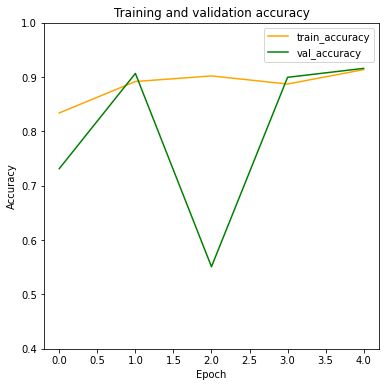

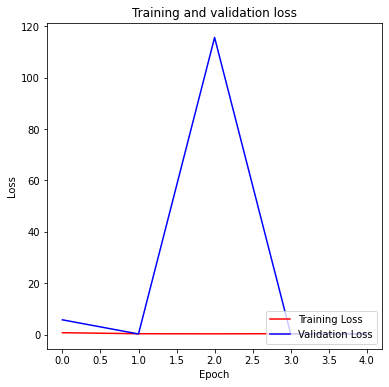

In [ ]:
# Plotting the performance of the model over training
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],'orange', label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], 'g', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.4, 1])
plt.title('Training and validation accuracy')
plt.show()

plt.figure(figsize=(6,6))
plt.plot( history.history['loss'], 'r', label='Training Loss')
plt.plot( history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.legend(loc = 'lower right')
plt.show()

The model achieved very good performance in both training and validation subset, with an accuracy of 91%. It does not show any overfitting issue. However, with this performance, keeping training may cause overfitting. 

### Evaluating the transfered CNN model

* **Observing the classification report** 

In [ ]:
# Testing the perfomance of the transfered model on the testing set that we have not touched when training
from sklearn.metrics import confusion_matrix, classification_report
## Getting the actual classes of the testing set
y_true = test_generated.classes
## Getting the label names of images
label_names = test_generated.class_indices
## Applying the model to predict on the test set
y_pred = np.argmax(tf_model.predict(test_generated), axis=-1) 
## Printing class
print(classification_report(y_true, y_pred,  target_names=label_names))


              precision    recall  f1-score   support

   buildings       0.94      0.88      0.91       437
      forest       0.98      0.99      0.99       474
     glacier       0.88      0.88      0.88       553
    mountain       0.90      0.84      0.87       525
         sea       0.90      0.95      0.92       510
      street       0.90      0.96      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



The transfered CNN model competely outperforms our previous CNN model with an accuracy of 92% on the test set that is even a bit better than it does on the training set. That means if we keep training, the model could perform better. Also, it has very high F1 score in all classes. With this high performance, we believe that our model can be deployed for predicting real world images. 

### Applying the model for predicting the real-world image
(Prediction set)

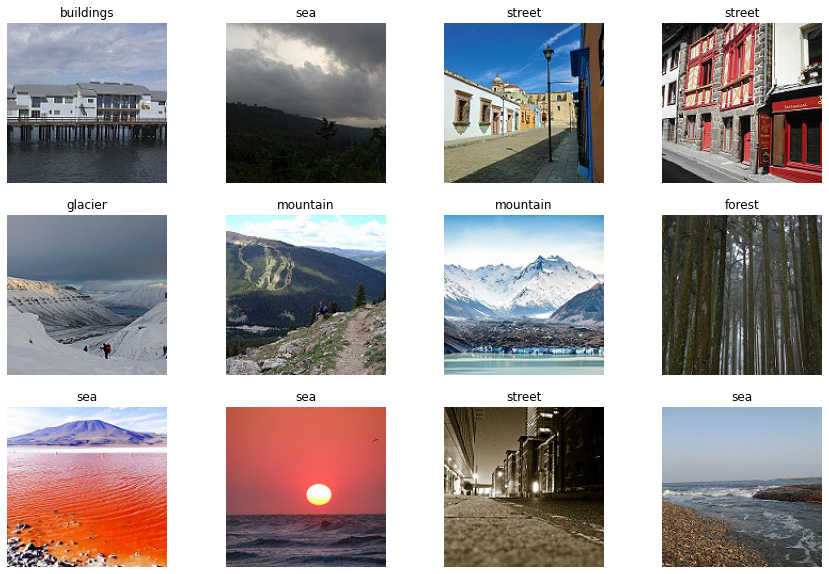

In [ ]:
# Defining the function for predicting the unseen data
#import PIL
#from PIL import Image
#from skimage import transform

def load_image(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

# Getting the encoded classes and labels
classes_decoded = dict([(v, k) for k, v in train_generated.class_indices.items()])

# Randomly picking up 12 images in the prediction set to predict
plt.figure(figsize=(15,10))
for i in range (12):
  ax = plt.subplot(3,4,i+1)
  img = load_image(pred_path)
  label=np.argmax(tf_model.predict(img[1]), axis=-1)
  plt.title(classes_decoded[int(label)])
  plt.imshow(img[0])
  plt.axis("off")
  



Incredibly, the model predicted correctly all random images. 

**Conclusion:** We built two convolution neural network(CNN) models to classify the given datasets into 6 categories. The CNN model built from scratch achieved an accuracy of 79% on the test set, and not so high F1 in the buildings and glacier categories. The second model is built based on the ResNet50V2 pretrained model. This transfered CNN model outperformed the first model with accuracy of 92% on the test set, and very good F1 scores in all categories.